In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
df_source = pd.read_csv('/content/done2.csv')
df_source.columns = ['time','x1','x2','x3','x4']
df_a=df_source.drop(['time'],axis=1)
#df_b = df_a.drop(range(4000,4095))
df_a

,x1,x2,x3,x4
0,-4.211426,89.999516,1.220703,90.000147
1,-3.784180,89.999101,-0.183105,89.992125
2,-3.662109,89.844273,-1.159668,89.992022
3,0.305176,89.844300,-0.915527,89.991948
4,1.342773,89.844421,-0.854492,89.979617
...,...,...,...,...
3250,NaN,NaN,-54.138184,16.526537
3251,NaN,NaN,-52.978516,14.382563
3252,NaN,NaN,-45.959473,14.376431
3253,NaN,NaN,-44.067383,14.371622


In [ ]:
merged_data = df_a
train = merged_data[0:1000]
test = merged_data[1001:1500]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (1000, 4)
Test dataset shape: (499, 4)


In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"


In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (1000, 1, 4)
Test data shape: (499, 1, 4)


In [ ]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu',return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1344      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [ ]:
nb_epochs = 25
batch_size = 5
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/25
190/190 [==============================] - 8s 12ms/step - loss: 0.3662 - val_loss: 0.1435
Epoch 2/25
190/190 [==============================] - 1s 6ms/step - loss: 0.1587 - val_loss: 0.1481
Epoch 3/25
190/190 [==============================] - 1s 6ms/step - loss: 0.1550 - val_loss: 0.1443
Epoch 4/25
190/190 [==============================] - 1s 5ms/step - loss: 0.1534 - val_loss: 0.1473
Epoch 5/25
190/190 [==============================] - 1s 6ms/step - loss: 0.1514 - val_loss: 0.1455
Epoch 6/25
190/190 [==============================] - 1s 7ms/step - loss: 0.1488 - val_loss: 0.1455
Epoch 7/25
190/190 [==============================] - 1s 6ms/step - loss: 0.1442 - val_loss: 0.1281
Epoch 8/25
190/190 [==============================] - 1s 6ms/step - loss: 0.1233 - val_loss: 0.1089
Epoch 9/25
190/190 [==============================] - 1s 6ms/step - loss: 0.1145 - val_loss: 0.1093
Epoch 10/25
190/190 [==============================] - 1s 6ms/step - loss: 0.1110 - val_loss: 0.106

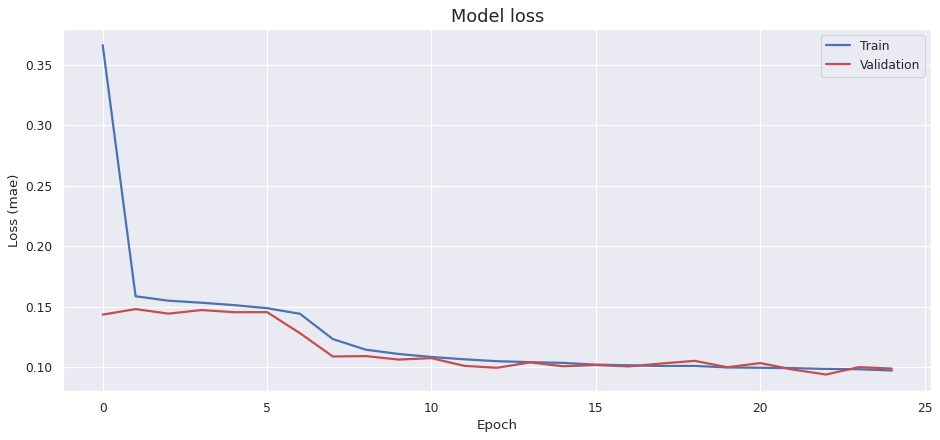

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

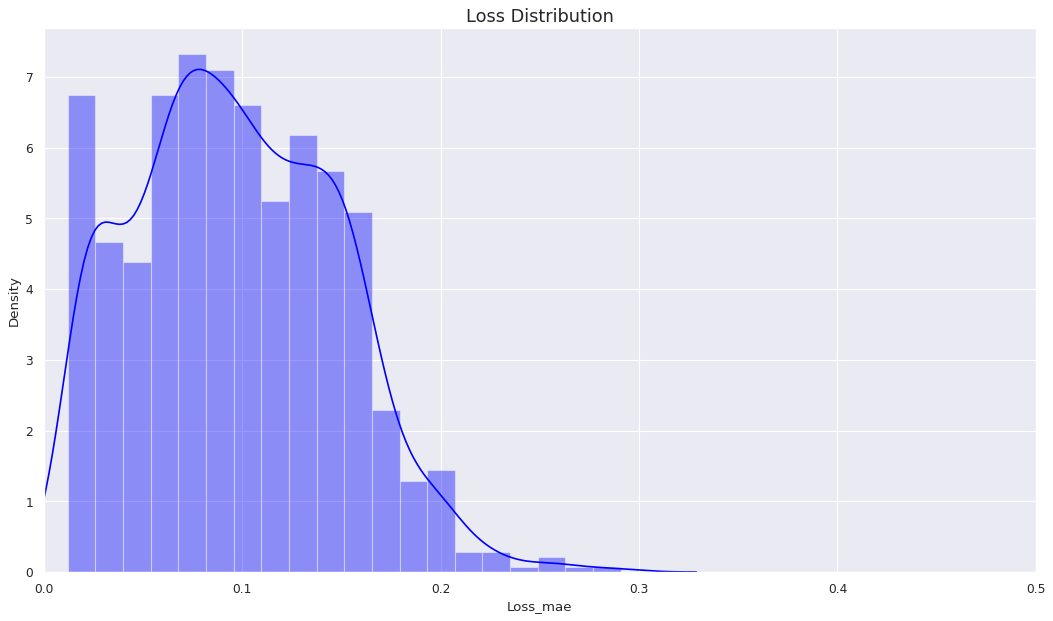

In [ ]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

In [ ]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])


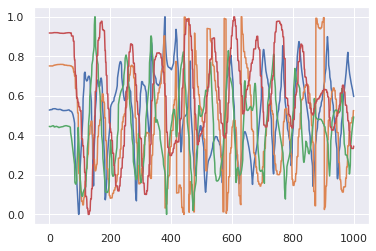

In [ ]:
plt.plot(Xtrain)

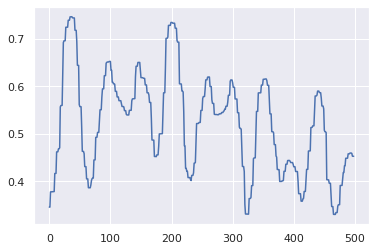

In [ ]:
Target2 = []
for i in range(0,499):
  Target2.append(Xtest[i][3])
#  Target.append(Xtest[i][3])
plt.plot(Target2)

In [ ]:

X_preda = X_pred.to_numpy()
X_preda[0][3]

0.60714436

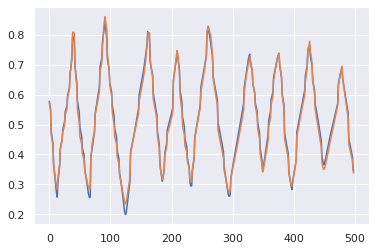

In [ ]:
Target2 = []
for i in range(0,499):
  Target2.append(Xtest[i][0])
#  Target.append(Xtest[i][3])
plt.plot(Target2)
Target22 = []
for i in range(0,499):
  Target22.append(X_preda[i][0])
#  Target.append(Xtest[i][3])
plt.plot(Target22)


In [ ]:
import numpy as np

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * (np.linalg.norm(b)))

print(cosine_similarity(Target2,Target22))

0.9996949067609866


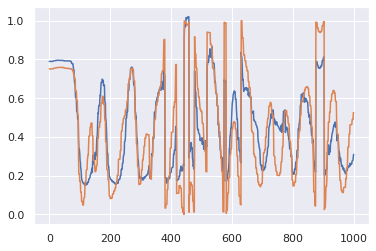

In [ ]:
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
plt.plot(X_pred_train['x2'])
#plt.plot(Xtrain)
Target = []
#plt.plot(X_pred_train['x1'])
for i in range(0,1000):
  Target.append(Xtrain[i][1])
plt.plot(Target)

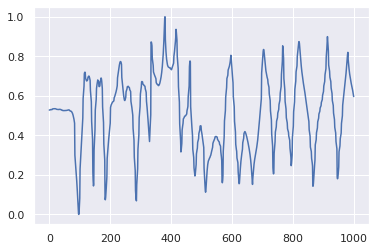

In [ ]:
Target = []
#plt.plot(X_pred_train['x1'])
for i in range(0,1000):
  Target.append(Xtrain[i][0])
plt.plot(Target)

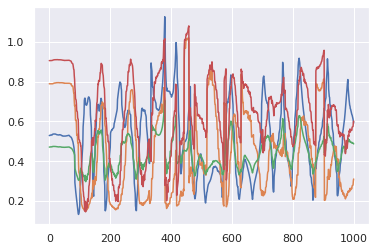

In [ ]:
plt.plot(X_pred_train)